<a href="https://colab.research.google.com/github/karthiksuresh8/ML_project/blob/main/SENTIMENT_ANALYSIS_USING_AI%26ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install emoji --

In [ ]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

#sklearn
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
from transformers import get_linear_schedule_with_warmup

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

seed=42

from torch.utils.data import Dataset, DataLoader
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import pipeline

In [ ]:
# Importing the DataSet
data = pd.read_csv('finalSentimentdata2.csv')

In [ ]:
data.head()

,Unnamed: 0,sentiment,text
0,3204,negative,agree the poor in india are treated badly thei...
1,1431,positive,if only i could have spent the with this cutie...
2,654,positive,will nature conservation remain a priority in ...
3,2530,negative,coronavirus disappearing in italy show this to...
4,2296,negative,uk records lowest daily virus death toll since...


In [ ]:
data.shape

(3090, 3)

In [ ]:
#A function to clean data it removes all the punctuation marks, urls etc
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
# Applying function to remove punctuations
data['text'] = data['text'].apply(lambda x: clean_text(x))

In [ ]:
#Function to remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

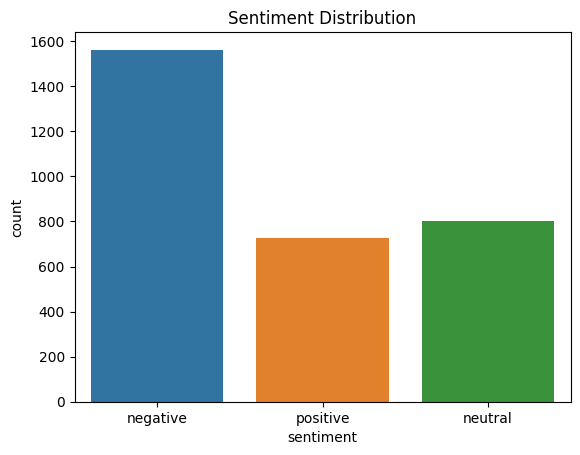

In [ ]:
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.show()

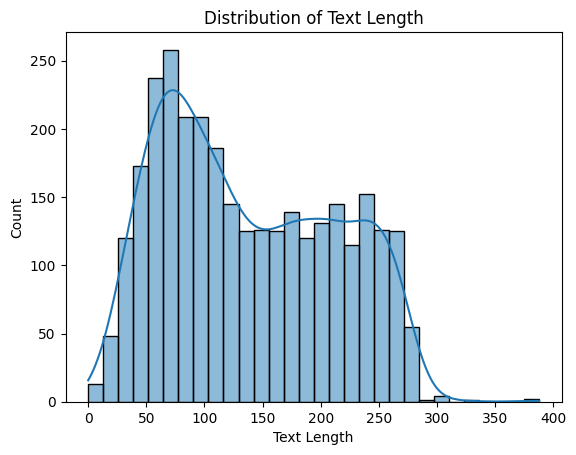

In [ ]:
# Assuming your DataFrame is named df
data['text_length'] = data['text'].apply(len)

sns.histplot(data['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()


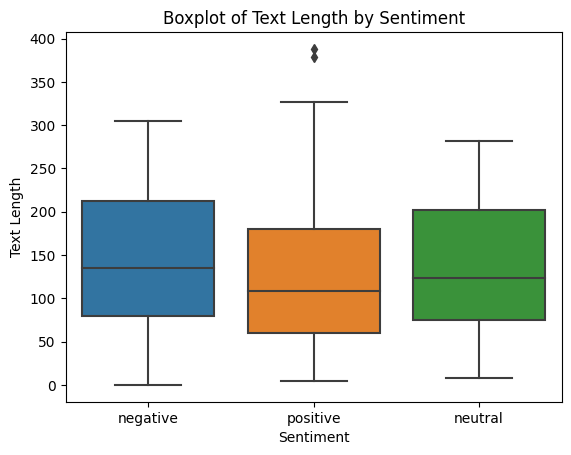

In [ ]:
sns.boxplot(x='sentiment', y='text_length', data=data)
plt.title('Boxplot of Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

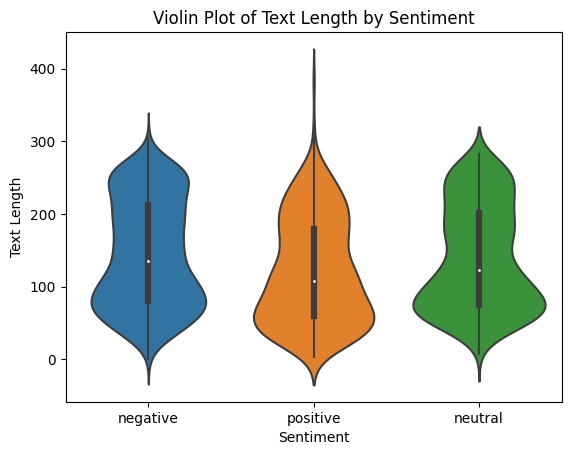

In [ ]:
# Assuming your DataFrame is named df
sns.violinplot(x='sentiment', y='text_length', data=data)
plt.title('Violin Plot of Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()

In [ ]:
#Tweet Max Lenght
data['text'].apply(lambda x:len(str(x).split())).max()

61

In [ ]:
# Taking 50 words from a tweet
example = data['text'][50]
print(example)

coronavirus could hit housing hard as australia teeters on edge of recession the guardian


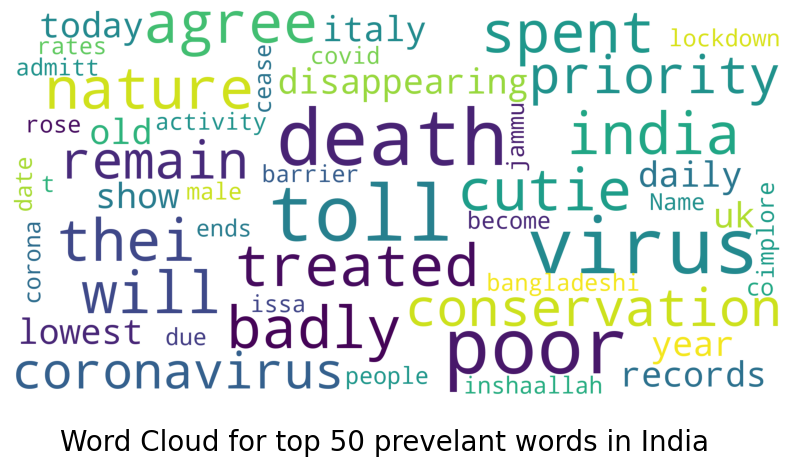

In [ ]:
#Word cloud of 50 most common words in India
from wordcloud import WordCloud, STOPWORDS
word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(data['text']))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.suptitle('Word Cloud for top 50 prevelant words in India', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb= LabelEncoder()

In [ ]:
lb.fit(data['sentiment'])

LabelEncoder()

In [ ]:
classes= list(lb.classes_)

In [ ]:
classes

['negative', 'neutral', 'positive']

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

In [ ]:
#This function is used to split a sentence or a piece of text into individual words or tokens.
tokens = nltk.word_tokenize(example)
tokens[:10]

['coronavirus',
 'could',
 'hit',
 'housing',
 'hard',
 'as',
 'australia',
 'teeters',
 'on',
 'edge']

In [ ]:
#Part-of-speech tagging is the process of assigning a part-of-speech category (such as noun, verb, adjective, etc.)
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('coronavirus', 'NN'),
 ('could', 'MD'),
 ('hit', 'VB'),
 ('housing', 'NN'),
 ('hard', 'JJ'),
 ('as', 'IN'),
 ('australia', 'JJ'),
 ('teeters', 'NNS'),
 ('on', 'IN'),
 ('edge', 'NN')]

In [ ]:
#Named Entity Recognition is a natural language processing task that involves identifying and classifying named entities
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  coronavirus/NN
  could/MD
  hit/VB
  housing/NN
  hard/JJ
  as/IN
  australia/JJ
  teeters/NNS
  on/IN
  edge/NN
  of/IN
  recession/NN
  the/DT
  guardian/NN)


In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
'''polarity score -
Polarity scores are usually represented as numerical values, where a positive score indicates a positive sentiment,
a negative score indicates a negative sentiment, and a score close to zero suggests a neutral sentiment.'''

sia.polarity_scores('I am so happy!')
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['text']
    myid = row['Unnamed: 0']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/3090 [00:00<?, ?it/s]

RoBERTa introduces dynamic masking, where different tokens are randomly chosen to be masked during each training iteration.

In [ ]:
#BERT and RoBERTa are transformer-based models for natural language processing (NLP).
#BERT uses a bidirectional transformer encoder, is trained with a masked language model (MLM) and next sentence prediction (NSP).
#RoBERTa simplifies training by focusing only on MLM, removes NSP, and introduces dynamic masking.

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

In [ ]:
from transformers import BertTokenizer

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sample_txt = 'These are tough times we must stand together'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: These are tough times we must stand together
   Tokens: ['these', 'are', 'tough', 'times', 'we', 'must', 'stand', 'together']
Token IDs: [2122, 2024, 7823, 2335, 2057, 2442, 3233, 2362]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
token_lens = []
for txt in data.text:

    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

<ipython-input-33-18d4a5ce9578>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

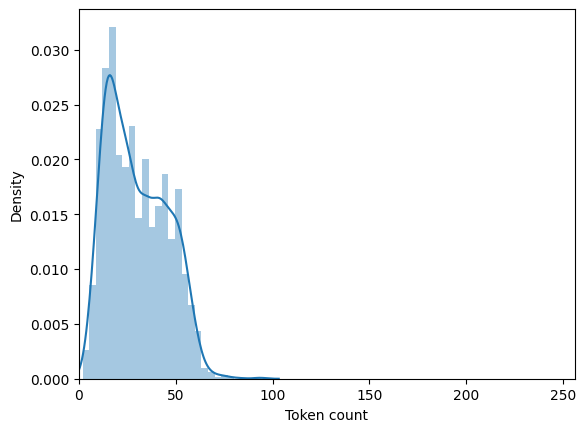

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
class Covid19Tweet(Dataset):

    def __init__(self, tweets, sentiment, tokenizer, max_len):


        self.tweets = tweets
        self.sentiment = sentiment
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.tweets)
    def __getitem__(self, item):

        tweets = str(self.tweets[item])
        sentiment = self.sentiment[item]
        encoding = self.tokenizer.encode_plus(
        tweets,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')
        return {
        'tweet_text': tweets,
         'input_ids': encoding['input_ids'].flatten(),
         'attention_mask': encoding['attention_mask'].flatten(),
         'sentiments': torch.tensor(sentiment, dtype=torch.long)
          }

In [ ]:
#Roberta Pretrained Model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.8074688, 'roberta_neu': 0.18310404, 'roberta_pos': 0.009427229}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
def analyseSentimentByMode(text):
    """
    Analyzes the sentiment of the given text using a sentiment analysis model.

    Parameters:
    - text (str): The input text for sentiment analysis.
    - sentiment_model: The sentiment analysis model (e.g., BERT, RoBERTa).

    Returns:
    - str: The predicted sentiment (e.g., 'positive', 'negative', 'neutral').
    """
    sent_pipeline = pipeline("sentiment-analysis")

    predicted_sentiment = sent_pipeline(text)
    print(predicted_sentiment)

    return predicted_sentiment

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})

In [ ]:
results_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound'], dtype='object')

In [ ]:
sent_pipeline = pipeline("sentiment-analysis")
user_input = input()
sent_pipeline(user_input)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
